In [ ]:
## Import analysis modules
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc
import graphviz
from sklearn import tree
from IPython.display import display, Image
%matplotlib inline

## Import visualization modules
import matplotlib.pyplot as plt


In [ ]:
## Read in file
train_original = pd.read_csv('/train.csv')
test_original = pd.read_csv('/test.csv')

In [ ]:
## Basic information about the training set
train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
## Basic information about the testing set
test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
# Exclude some features to reduce data dimension
train=train_original.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
test=test_original.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
total = [train,test]

train.shape, test.shape

((891, 8), (418, 7))

In [ ]:
# Define features and target variable
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

In [ ]:
# Define transformers for preprocessing
numeric_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Sex', 'Embarked']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])

In [ ]:
# Build the full pipeline including preprocessing and classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=1)),
])


In [ ]:
# Split the data into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(train[features], train[target], test_size=.30, random_state=1)


In [ ]:
# Fit the model
pipeline.fit(x_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('classifier', DecisionTreeClassifier(random_state=1))])

In [ ]:
# Run 10 fold cross validation
cvs = cross_val_score(pipeline, train[features], train[target], cv=10)
print(cvs)

[0.73333333 0.80898876 0.71910112 0.75280899 0.83146067 0.78651685
 0.80898876 0.75280899 0.83146067 0.82022472]


In [ ]:
# Show cross validation score mean and std
print("Accuracy: %0.4f (+/- %0.4f)" % (cvs.mean(), cvs.std()*2))


Accuracy: 0.7846 (+/- 0.0795)


In [ ]:
# Evaluate the model on the validation set
predictions = pipeline.predict(x_test)


In [ ]:
print("Precision: %0.4f" % precision_score(y_test, predictions))

Precision: 0.7353


In [ ]:
print("Recall: %0.4f" % recall_score(y_test, predictions))

Recall: 0.6522


In [ ]:
# Print metrics
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       153
           1       0.74      0.65      0.69       115

    accuracy                           0.75       268
   macro avg       0.75      0.74      0.74       268
weighted avg       0.75      0.75      0.75       268



Passenger ID: 893
Prediction (0: Not Survived, 1: Survived): [1]


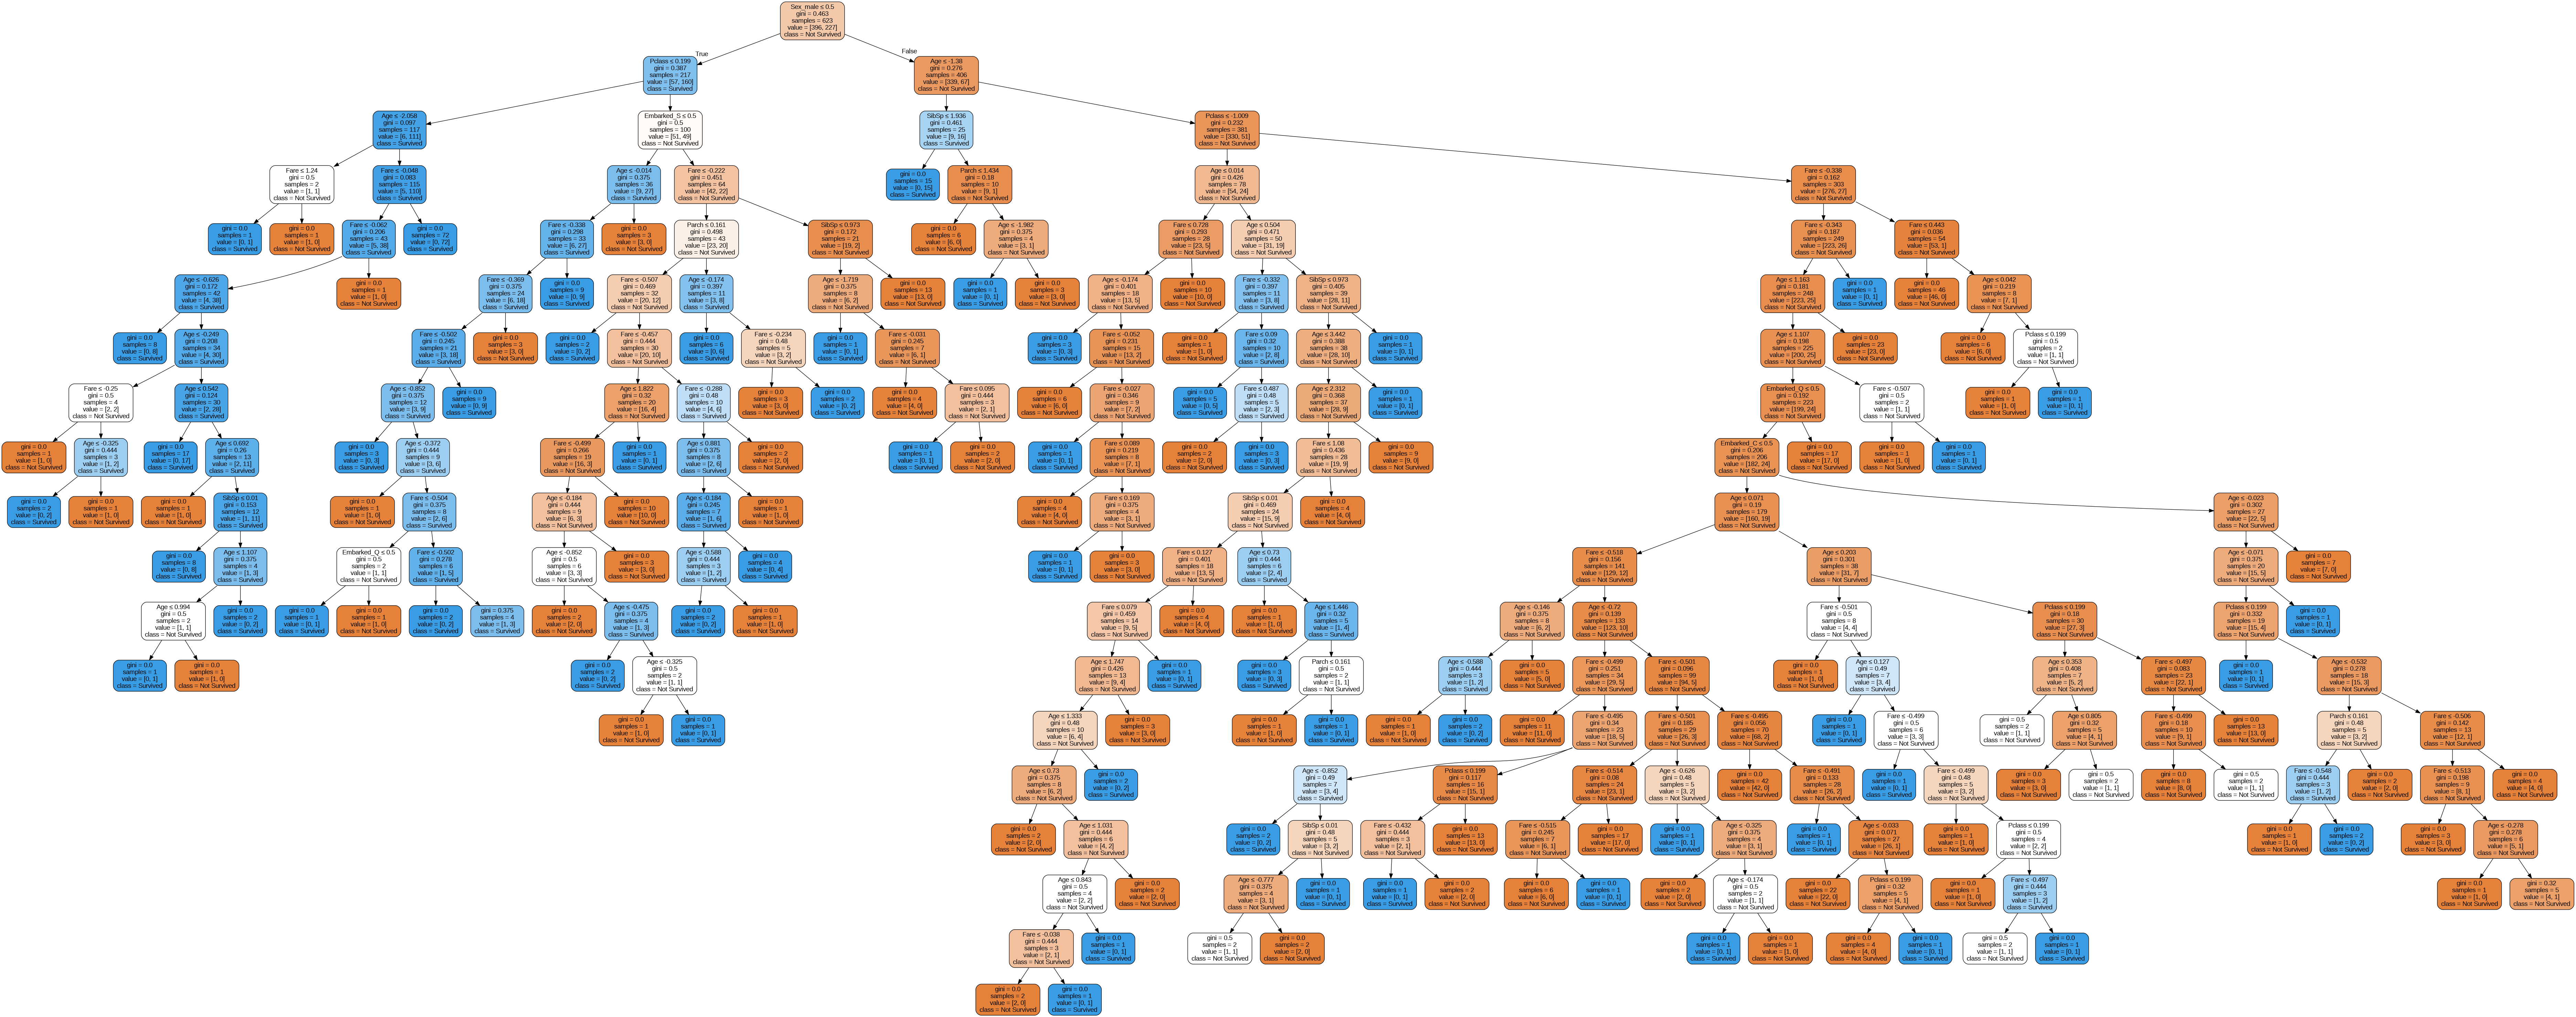

In [ ]:
# Define function to predict and visualize decision tree
def predict_and_visualize(passenger_id, pipeline, features, numeric_features, categorical_features):
    # Extract the information for the given passenger_id
    passenger_info = test_original.loc[test_original['PassengerId'] == passenger_id, features]

    # Make prediction
    prediction = pipeline.predict(passenger_info)

    # Print passenger information and prediction
    print("Passenger ID:",passenger_id)
    # print(passenger_info)
    print("Prediction (0: Not Survived, 1: Survived):", prediction)

    # Extract the decision tree from the pipeline
    tree_clf = pipeline.named_steps['classifier']

    # Get feature names after one-hot encoding
    feature_names = numeric_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat']
                                            .named_steps['onehot'].get_feature_names_out(categorical_features))

    class_names = ['Not Survived', 'Survived']

    # Export the decision tree to a DOT file
    dot_data = export_graphviz(tree_clf, out_file=None,
                               feature_names=feature_names,
                               class_names=class_names,
                               filled=True, rounded=True, special_characters=True)

    # Visualize the decision tree using graphviz
    graph = graphviz.Source(dot_data)
    graph.render(filename='decision_tree', format='png', cleanup=True)
    display(Image(filename='decision_tree.png'))

# Example: Predict and visualize for PassengerId = 1
passenger_id_to_predict = 893
predict_and_visualize(passenger_id_to_predict, pipeline, features, numeric_features, categorical_features)
